In [1]:
import pandas as pd
import gym
import numpy as no
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
import numpy as np
from gym.envs.toy_text import CliffWalkingEnv
sns.set()

In [2]:
env1 = CliffWalkingEnv()
env2 = gym.make('Taxi-v3')

In [3]:
env1.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [4]:
env2.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
print(env1.__doc__)
print(env2.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    
None


# Creating an agent

In [6]:
class QLearning:
    def __init__(self, n_actions, n_states, epsilon=0.5, gamma=0.8, eta=0.5):
        self.n_actions = n_actions
        self.q_table = np.zeros(shape=(n_states,n_actions))
        self.epsilon = epsilon
        self.gamma = gamma
        self.eta = eta
    
    def argmax(self,q_table):
        max_value = np.max(q_table)
        idxs = np.where(q_table==max_value)[0]
        if idxs.shape[0]>1:
            return np.random.choice(idxs)
        else:
            print('made argmax')
            return np.argmax(q_table)
    
    def get_action(self,state):
        if np.random.rand()<self.epsilon:
            action = np.random.choice(range(self.n_actions))
        else:
            action = np.argmax(self.q_table[state])
        return action
    
    def update(self, state, action, next_state, reward):
        self.q_table[state,action]+=self.eta*(reward+self.gamma*np.max(self.q_table[next_state])-self.q_table[state,action])
        
        

# Training an agent 

In [7]:
def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

def show_progress(reward_per_episode,steps_per_episode):
    clear_output(True)
    fig, ax = plt.subplots(3,1)
    ax[0].plot(reward_per_episode,label='reward per episode')
    ax[0].legend()
    ax[0].set_ylim(-100,100)
    ax[1].plot(steps_per_episode, label = 'steps per episode')
    ax[1].legend()
    ax[2].plot(moving_average(reward_per_episode), label='moving reward')
    ax[2].legend()
    ax[2].set_ylim(-100, 100)
    fig.tight_layout() 
    plt.show()
    
def train_and_play(agent, env, t_max=10**4, render=False):
    s = env.reset()
    rewards = []
    steps = 0
    for t in range(t_max):
        a = agent.get_action(s)
        new_s, r, done, _ = env.step(a)
        rewards.append(r)
        agent.update(s,a,new_s,r)
        s = new_s
        if render:
            clear_output(True)
            env.render()
        if done:
            break
        steps+=1
    return  agent, rewards, steps
    

def train_loop(env, agent, n_episodes=1000, epsilon_discount=False,
              per_episode=100):
    reward_per_episode = []
    steps_per_episode = []
    if epsilon_discount:
        agent.epsilon = 1
    for episode in range(1,n_episodes+1):
        if epsilon_discount:
            agent.epsilon*=0.999
        agent, rewards, steps = train_and_play(agent, env)
        reward_per_episode.append(np.sum(rewards))
        steps_per_episode.append(steps) 
        if episode%per_episode==0:
            show_progress(reward_per_episode,steps_per_episode)
            print(f'Reward sum : {np.sum(rewards)}')
            print(f'Mean reward : {np.mean(reward_per_episode[-100:])}')
            print(f'agent.epsilon : {agent.epsilon}')

    return agent

## Training on Cliff-Walking env

In [8]:
n_actions = env1.action_space.n
n_states = env1.observation_space.n

In [9]:
epsilon = 1
gamma = 0.9
eta = 0.1
episodes = 5000
epsilon_discount = True

In [10]:
agent = QLearning(n_actions,n_states, epsilon=epsilon, gamma=gamma, eta=eta)

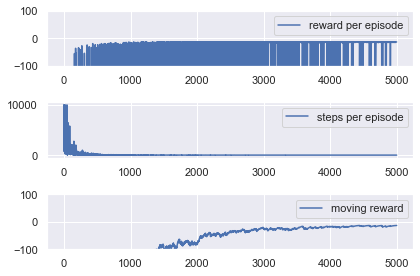

Reward sum : -13
Mean reward : -14.19
agent.epsilon : 0.006721111959865607


In [11]:
agent = train_loop(env1,agent,episodes, epsilon_discount)

## Visualization on Cliff-Walking env

In [12]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_action(yi * n_cols + xi)], end='')
        print()

In [13]:
draw_policy(env1,agent)

 v  v  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


## Training on Taxi-v3 env

In [14]:
def train_and_play(agent, env, render=False):
    s = env.reset()
    rewards = []
    steps = 0
    while True:
        a = agent.get_action(s)
        new_s, r, done, _ = env.step(a)
        rewards.append(r)
        agent.update(s,a,new_s,r)
        s = new_s
        if render:
            clear_output(True)
            env.render()
        if done:
            break
        steps+=1
    return  agent, rewards, steps

In [15]:
n_actions = env2.action_space.n
n_states = env2.observation_space.n

In [16]:
epsilon = 0.1
gamma = 0.9
eta = 0.1
episodes = 20000
epsilon_discount = True

In [17]:
agent = QLearning(n_actions,n_states, epsilon=epsilon, gamma=gamma, eta=eta)

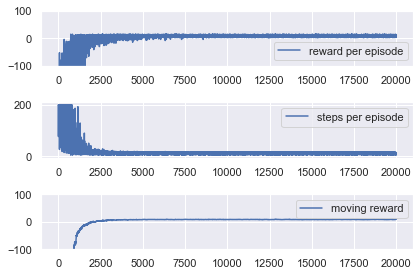

Reward sum : 13
Mean reward : 8.47
agent.epsilon : 2.040631186762095e-09


In [18]:
agent = train_loop(env2,agent,episodes, epsilon_discount,per_episode=100)

## Visualization on Taxi-v3

In [19]:
def visualize(agent,env):
    rewards = []
    penalties = 0
    for i_episode in range(100):
        state = env.reset()
        done = False
        counter = 0
        while not done:
            counter+=1
            env.render()
            action = agent.get_action(state)
            observation, reward, done, info = env.step(action)
            if reward==-10:
                penalties+=1
            rewards.append(reward)
            state = observation
            if done:
                print("Episode finished after {} timesteps".format(counter))
                break
    print(f'Mean reward : {np.mean(rewards)}')
    print(f'Average number of penalties : {penalties/100}')
    env.close()

In [20]:
visualize(agent, env2)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: 

  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Episode finished after 9 timesteps
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | :_|
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |

  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Episode finished after 11 timesteps
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|

  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Episode finished after 16 timesteps
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|